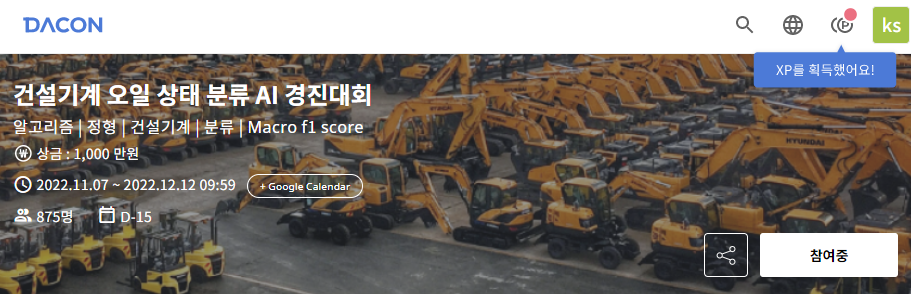

In [3267]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import f1_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

import os
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import random
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore') 

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3268]:
file_version = 33
CFG = {
    'EPOCHS': 30,
    'LEARNING_RATE':1e-2,    # 0.01
    'BATCH_SIZE':256,  #256
    'SEED':43,
    'log_transform_turn': 1,  # 로그 트랜스폼을 몇번 돌릴 것인가?
    'skew_cut':0.01,           # 왜도 얼마 이상을 로그값으로 정규화할 것인가?(100이면 안하겠다는 것)
    'vif_cut': 10,           # 다중공선성 vif 얼마 이상을 제거할 것인가?
    'corr_cut': 0.0075,     # 일정 상관관계 이하 칼럼은 드랍
    'outlier_corr_cut': 100,    # 이값 이상의 상관관계를 갖는 칼럼에 대해서만 아웃라이어 제거(100이면 미적용)
    'T_Thresh': 0.3,     # Teacher model train Threshhold 최초 0.35
    'S_Thresh': 0.325,     # Student model train Threshold 최초 0.35
    'reduct' : 'sum',      # sum, mean
    'drop_rate': 0.2,
    
}

In [3269]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED'])

# 1. EDA

- 결측치 처리
- 왜도 정규화 처리
- 스케일링
- 다중공선성 검토

In [3270]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

In [3271]:
train["Y_LABEL"].value_counts()

0    12892
1     1203
Name: Y_LABEL, dtype: int64

In [3272]:
# train.info()

In [3273]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6041 entries, 0 to 6040
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   6041 non-null   object 
 1   COMPONENT_ARBITRARY  6041 non-null   object 
 2   ANONYMOUS_1          6041 non-null   int64  
 3   YEAR                 6041 non-null   int64  
 4   ANONYMOUS_2          6041 non-null   int64  
 5   AG                   6041 non-null   int64  
 6   CO                   6041 non-null   int64  
 7   CR                   6041 non-null   int64  
 8   CU                   6041 non-null   int64  
 9   FE                   6041 non-null   int64  
 10  H2O                  6041 non-null   float64
 11  MN                   6041 non-null   int64  
 12  MO                   6041 non-null   int64  
 13  NI                   6041 non-null   int64  
 14  PQINDEX              6041 non-null   int64  
 15  TI                   6041 non-null   i

## (1) 결측치

<AxesSubplot:>

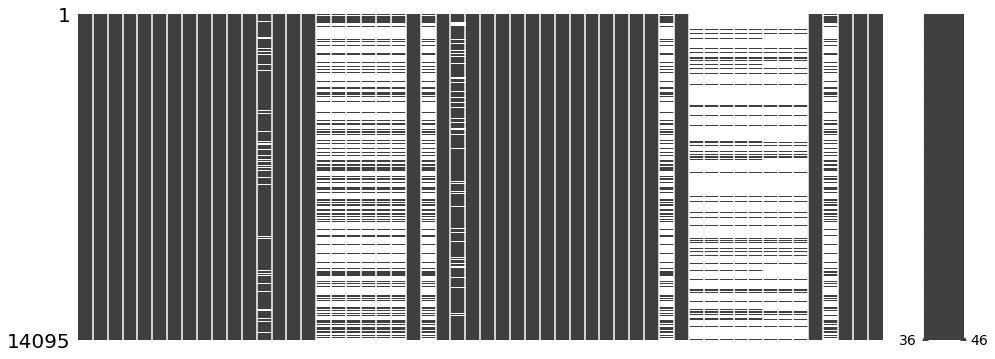

In [3274]:
import missingno as msno
msno.matrix(train, figsize=(16,6))

In [3275]:
train.describe(include="all")

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,...,U25,U20,U14,U6,U4,V,V100,V40,ZN,Y_LABEL
count,14095,14095,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,...,2316.000000,2316.000000,2118.000000,2118.000000,2118.000000,14095.000000,3724.000000,14095.000000,14095.000000,14095.000000
unique,14095,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,TRAIN_00000,COMPONENT3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,7050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,3146.082937,2013.652501,7.600568,387.416885,0.025825,12.707698,64.026179,0.692799,...,29.870898,56.063472,239.938149,5488.693107,19415.597262,0.050656,13.576230,109.355815,588.646825,0.085349
std,NaN,NaN,4216.089809,3.964758,11.681628,550.016073,0.171926,86.968000,102.876871,2.905491,...,97.459625,184.332678,685.053457,15474.146283,40145.311444,0.475438,1.073718,49.612379,531.743393,0.279411
min,NaN,NaN,1000.000000,2007.000000,0.000000,200.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,15.000000,154.000000,0.000000,5.200000,2.900000,0.000000,0.000000
25%,NaN,NaN,1655.000000,2010.000000,3.000000,200.000000,0.000000,1.000000,3.000000,0.000000,...,3.000000,5.000000,22.000000,636.750000,5409.250000,0.000000,12.900000,71.800000,37.000000,0.000000
50%,NaN,NaN,2227.000000,2014.000000,5.000000,200.000000,0.000000,2.000000,11.000000,0.000000,...,7.000000,13.000000,57.000000,1753.000000,12691.500000,0.000000,13.500000,111.300000,520.000000,0.000000
75%,NaN,NaN,3797.000000,2017.000000,8.000000,410.000000,0.000000,4.000000,110.000000,0.000000,...,23.000000,39.250000,189.000000,5517.750000,24535.750000,0.000000,14.200000,137.200000,1119.000000,0.000000


In [3276]:
def 보간값(col):
    평균 = train[col].mean()
    중위수 = train[col].median()
    최빈값 = train[col].mode().values[0]
    return {"평균": 평균, "중위수": 중위수, "최빈값":최빈값}

In [3277]:
null_columns = []
for col in train.columns.tolist():
    if train[col].isna().any():
        null_columns.append(col)
        평균 = 보간값(col)["평균"]
        중위수 = 보간값(col)["중위수"]
        최빈값 = 보간값(col)["최빈값"]
        print(f"칼럼명: {col}, 평균: {평균:.2f}, 중위수: {중위수}, 최빈값: {최빈값}")
    else:
        pass   

칼럼명: CD, 평균: 0.02, 중위수: 0.0, 최빈값: 0.0
칼럼명: FH2O, 평균: 15.24, 중위수: 13.0, 최빈값: 14.0
칼럼명: FNOX, 평균: 7.14, 중위수: 7.0, 최빈값: 6.0
칼럼명: FOPTIMETHGLY, 평균: 0.53, 중위수: 0.0, 최빈값: 0.0
칼럼명: FOXID, 평균: 12.50, 중위수: 12.0, 최빈값: 11.0
칼럼명: FSO4, 평균: 20.28, 중위수: 20.0, 최빈값: 20.0
칼럼명: FTBN, 평균: 8.78, 중위수: 8.7, 최빈값: 8.2
칼럼명: FUEL, 평균: 0.19, 중위수: 0.0, 최빈값: 0.0
칼럼명: K, 평균: 3.61, 중위수: 2.0, 최빈값: 0.0
칼럼명: SOOTPERCENTAGE, 평균: 0.61, 중위수: 0.4, 최빈값: 0.2
칼럼명: U100, 평균: 0.17, 중위수: 0.0, 최빈값: 0.0
칼럼명: U75, 평균: 0.42, 중위수: 0.0, 최빈값: 0.0
칼럼명: U50, 평균: 6.19, 중위수: 1.0, 최빈값: 0.0
칼럼명: U25, 평균: 29.87, 중위수: 7.0, 최빈값: 1.0
칼럼명: U20, 평균: 56.06, 중위수: 13.0, 최빈값: 4.0
칼럼명: U14, 평균: 239.94, 중위수: 57.0, 최빈값: 14.0
칼럼명: U6, 평균: 5488.69, 중위수: 1753.0, 최빈값: 300.0
칼럼명: U4, 평균: 19415.60, 중위수: 12691.5, 최빈값: 6789.0
칼럼명: V100, 평균: 13.58, 중위수: 13.5, 최빈값: 13.3


In [3278]:
train[null_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14095 entries, 0 to 14094
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CD              12701 non-null  float64
 1   FH2O            3890 non-null   float64
 2   FNOX            3890 non-null   float64
 3   FOPTIMETHGLY    3890 non-null   float64
 4   FOXID           3890 non-null   float64
 5   FSO4            3890 non-null   float64
 6   FTBN            3890 non-null   float64
 7   FUEL            3890 non-null   float64
 8   K               11796 non-null  float64
 9   SOOTPERCENTAGE  3890 non-null   float64
 10  U100            2316 non-null   float64
 11  U75             2316 non-null   float64
 12  U50             2316 non-null   float64
 13  U25             2316 non-null   float64
 14  U20             2316 non-null   float64
 15  U14             2118 non-null   float64
 16  U6              2118 non-null   float64
 17  U4              2118 non-null  

In [3279]:
print(null_columns)

['CD', 'FH2O', 'FNOX', 'FOPTIMETHGLY', 'FOXID', 'FSO4', 'FTBN', 'FUEL', 'K', 'SOOTPERCENTAGE', 'U100', 'U75', 'U50', 'U25', 'U20', 'U14', 'U6', 'U4', 'V100']


In [3280]:

# for i in null_columns:
#     print(train.groupby(by=["COMPONENT_ARBITRARY"])[i].agg(pd.Series.mode))

In [3281]:
df1=train.groupby("COMPONENT_ARBITRARY")[["FTBN"]].mean()
df1

,FTBN
COMPONENT_ARBITRARY,
COMPONENT1,8.783239
COMPONENT2,NaN
COMPONENT3,NaN
COMPONENT4,NaN


In [3282]:
df2=train.groupby(["COMPONENT_ARBITRARY","YEAR"])[["FTBN"]].mean()
df2

FTBN
COMPONENT_ARBITRARY YEAR          
COMPONENT1          2007  9.138356
                    2008  9.784833
                    2009  9.265992
                    2010  9.352000
                    2011  9.110794
...                            ...
COMPONENT4          2018       NaN
                    2019       NaN
                    2020       NaN
                    2021       NaN
                    2022       NaN

[64 rows x 1 columns]

In [3283]:
for i in null_columns:
#     print(train.groupby("COMPONENT_ARBITRARY")[i].median())

    train[i].fillna(train.groupby(["COMPONENT_ARBITRARY","YEAR"])[i].transform("mean"),inplace=True)
#     train[i].fillna(train.groupby("COMPONENT_ARBITRARY")[[i]].mean()

In [3284]:
train[null_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14095 entries, 0 to 14094
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CD              14095 non-null  float64
 1   FH2O            3890 non-null   float64
 2   FNOX            3890 non-null   float64
 3   FOPTIMETHGLY    3890 non-null   float64
 4   FOXID           3890 non-null   float64
 5   FSO4            3890 non-null   float64
 6   FTBN            3890 non-null   float64
 7   FUEL            3890 non-null   float64
 8   K               14095 non-null  float64
 9   SOOTPERCENTAGE  3890 non-null   float64
 10  U100            2316 non-null   float64
 11  U75             2316 non-null   float64
 12  U50             2316 non-null   float64
 13  U25             2316 non-null   float64
 14  U20             2316 non-null   float64
 15  U14             2316 non-null   float64
 16  U6              2316 non-null   float64
 17  U4              2316 non-null  

In [3285]:
# nan 보간 : 평균 or 중위수 or 최빈값
# 보간값적용 = "최빈값"
# result = []
# def 보간값대체(val):
#     for col in null_columns:
#         a = 보간값(col)[val] # 최빈값
# #         print(a)
#         train[col] = train[col].fillna(a)
#         result.append(a)
#     return result
# print(보간값대체(보간값적용))

<AxesSubplot:>

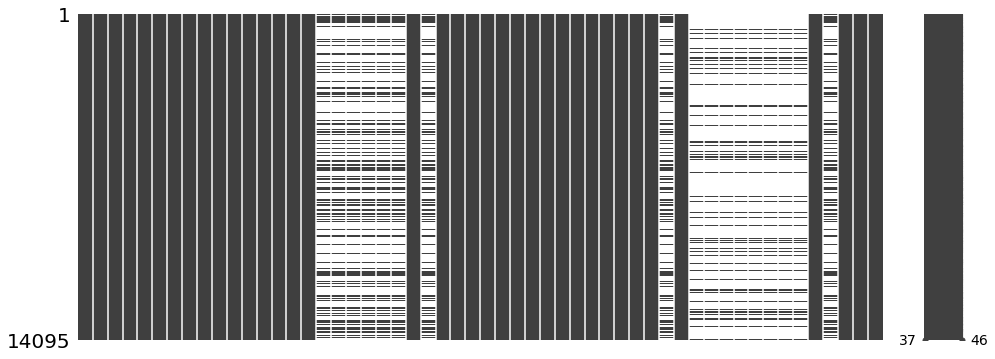

In [3286]:
msno.matrix(train, figsize=(16,6))

In [3287]:
null_columns = []
for col in train.columns.tolist():
    if train[col].isna().any():
        null_columns.append(col)
        평균 = 보간값(col)["평균"]
        중위수 = 보간값(col)["중위수"]
        최빈값 = 보간값(col)["최빈값"]
        print(f"칼럼명: {col}, 평균: {평균:.2f}, 중위수: {중위수}, 최빈값: {최빈값}")
    else:
        pass   

칼럼명: FH2O, 평균: 15.24, 중위수: 13.0, 최빈값: 14.0
칼럼명: FNOX, 평균: 7.14, 중위수: 7.0, 최빈값: 6.0
칼럼명: FOPTIMETHGLY, 평균: 0.53, 중위수: 0.0, 최빈값: 0.0
칼럼명: FOXID, 평균: 12.50, 중위수: 12.0, 최빈값: 11.0
칼럼명: FSO4, 평균: 20.28, 중위수: 20.0, 최빈값: 20.0
칼럼명: FTBN, 평균: 8.78, 중위수: 8.7, 최빈값: 8.2
칼럼명: FUEL, 평균: 0.19, 중위수: 0.0, 최빈값: 0.0
칼럼명: SOOTPERCENTAGE, 평균: 0.61, 중위수: 0.4, 최빈값: 0.2
칼럼명: U100, 평균: 0.17, 중위수: 0.0, 최빈값: 0.0
칼럼명: U75, 평균: 0.42, 중위수: 0.0, 최빈값: 0.0
칼럼명: U50, 평균: 6.19, 중위수: 1.0, 최빈값: 0.0
칼럼명: U25, 평균: 29.87, 중위수: 7.0, 최빈값: 1.0
칼럼명: U20, 평균: 56.06, 중위수: 13.0, 최빈값: 4.0
칼럼명: U14, 평균: 239.49, 중위수: 70.0, 최빈값: 201.73509933774835
칼럼명: U6, 평균: 5470.48, 중위수: 2164.5, 최빈값: 4350.417218543046
칼럼명: U4, 평균: 19450.01, 중위수: 14038.0, 최빈값: 19158.139072847684
칼럼명: V100, 평균: 13.58, 중위수: 13.6, 최빈값: 13.3


In [3288]:
train.drop(columns = null_columns, axis = 1, inplace = True)

In [3289]:
train.columns, train.shape

(Index(['ID', 'COMPONENT_ARBITRARY', 'ANONYMOUS_1', 'YEAR',
        'SAMPLE_TRANSFER_DAY', 'ANONYMOUS_2', 'AG', 'AL', 'B', 'BA', 'BE', 'CA',
        'CD', 'CO', 'CR', 'CU', 'FE', 'H2O', 'K', 'LI', 'MG', 'MN', 'MO', 'NA',
        'NI', 'P', 'PB', 'PQINDEX', 'S', 'SB', 'SI', 'SN', 'TI', 'V', 'V40',
        'ZN', 'Y_LABEL'],
       dtype='object'),
 (14095, 37))

In [3290]:
# for i in null_columns:
# #     print(train.groupby("COMPONENT_ARBITRARY")[i].median())
#     최빈값 = train[i].mode().values[0]
#     중위값 = train[i].median()
#     평균값 = train[i].mean()
#     train[i].fillna(중위값, inplace=True)
# #     train[i].fillna(train.groupby("COMPONENT_ARBITRARY")[[i]].mean()

<AxesSubplot:>

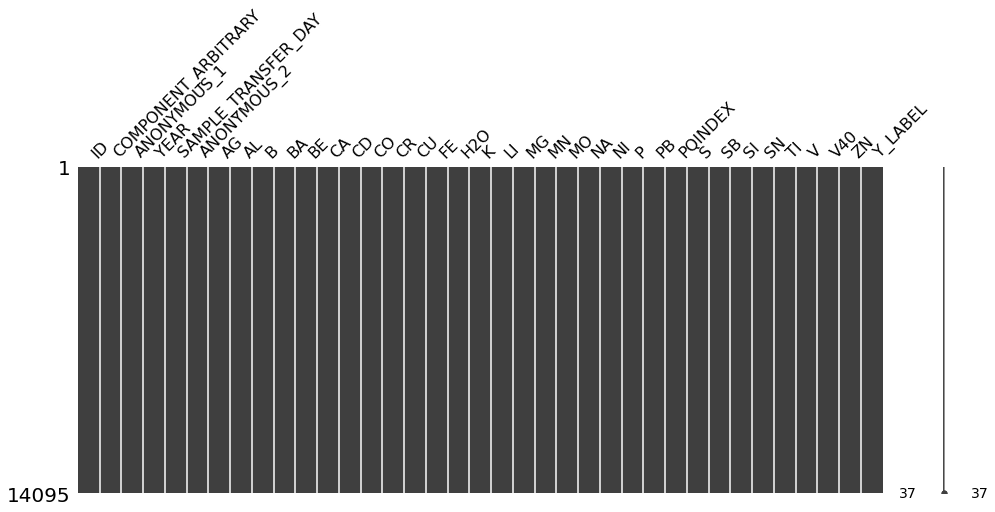

In [3291]:
msno.matrix(train, figsize=(16,6))

In [3292]:
# null_columns = []
# for col in train.columns.tolist():
#     if train[col].isna().any():
#         null_columns.append(col)
#         평균 = 보간값(col)["평균"]
#         중위수 = 보간값(col)["중위수"]
#         최빈값 = 보간값(col)["최빈값"]
#         print(f"칼럼명: {col}, 평균: {평균:.2f}, 중위수: {중위수}, 최빈값: {최빈값}")
#     else:
#         pass   

In [3293]:
y1 = [2019, 2020, 2022, 2021, 2007]
y2 = [2017, 2018, 2016]
y3 = [2015, 2012, 2013]
y4 = [2011, 2014]
y5 = [2010, 2009, 2008]

def year_grouping(year):
    if year in y1:
        return "y1"
    elif year in y2:
        return "y2"
    elif year in y3:
        return "y3"
    elif year in y4:
        return "y4"
    else:
        return "y5" 

In [3294]:
train["YEAR"] = train["YEAR"].apply(year_grouping)
train["YEAR"].value_counts()

y3    3418
y5    3234
y2    2716
y4    2546
y1    2181
Name: YEAR, dtype: int64

In [3295]:
test["YEAR"] = test["YEAR"].apply(year_grouping)
test["YEAR"].value_counts()

y3    1494
y5    1404
y2    1155
y4    1032
y1     956
Name: YEAR, dtype: int64

In [3296]:
s1 = [2, 3, 4, 5, 6]
s2 = [1, 7, 8, 9, 10, 11, 12, 13, 14]

def sample_day_grouping(day):
    if day in s1:
        return "s1"
    elif day in s2:
        return "s2"
    else:
        return "s3" 


In [3297]:
train["SAMPLE_TRANSFER_DAY"] = train["SAMPLE_TRANSFER_DAY"].apply(sample_day_grouping)
train["SAMPLE_TRANSFER_DAY"].value_counts()

s1    8313
s2    4614
s3    1168
Name: SAMPLE_TRANSFER_DAY, dtype: int64

## (2) 왜도 검토 - `Log Transform`

In [3298]:
# not_number_features = ['ID','COMPONENT_ARBITRARY', 'YEAR', "Y_LABEL"]
not_number_features = ['ID','COMPONENT_ARBITRARY', 'SAMPLE_TRANSFER_DAY','YEAR', "Y_LABEL"]

numerical_cols = list(set(train.columns.tolist())-set(not_number_features))
print(numerical_cols)
print(len(numerical_cols))

['SN', 'ANONYMOUS_2', 'TI', 'P', 'H2O', 'S', 'FE', 'BE', 'CA', 'NI', 'PQINDEX', 'V40', 'MN', 'CU', 'K', 'PB', 'SB', 'CR', 'CD', 'AG', 'B', 'NA', 'LI', 'ZN', 'ANONYMOUS_1', 'SI', 'BA', 'MO', 'AL', 'CO', 'MG', 'V']
32


In [3299]:
#박스 플롯
def box_plot(df):
    세로열 = 3
    가로열 = int(len(numerical_cols)/세로열+1)

    fig, axes = plt.subplots(가로열, 3, figsize=(18, 30))
    a = 0
    for i, col in enumerate(numerical_cols):
            b=i%3
            sns.boxplot(ax=axes[a, b], data=df, x='Y_LABEL', y=col)
            if b == 2:
                a += 1

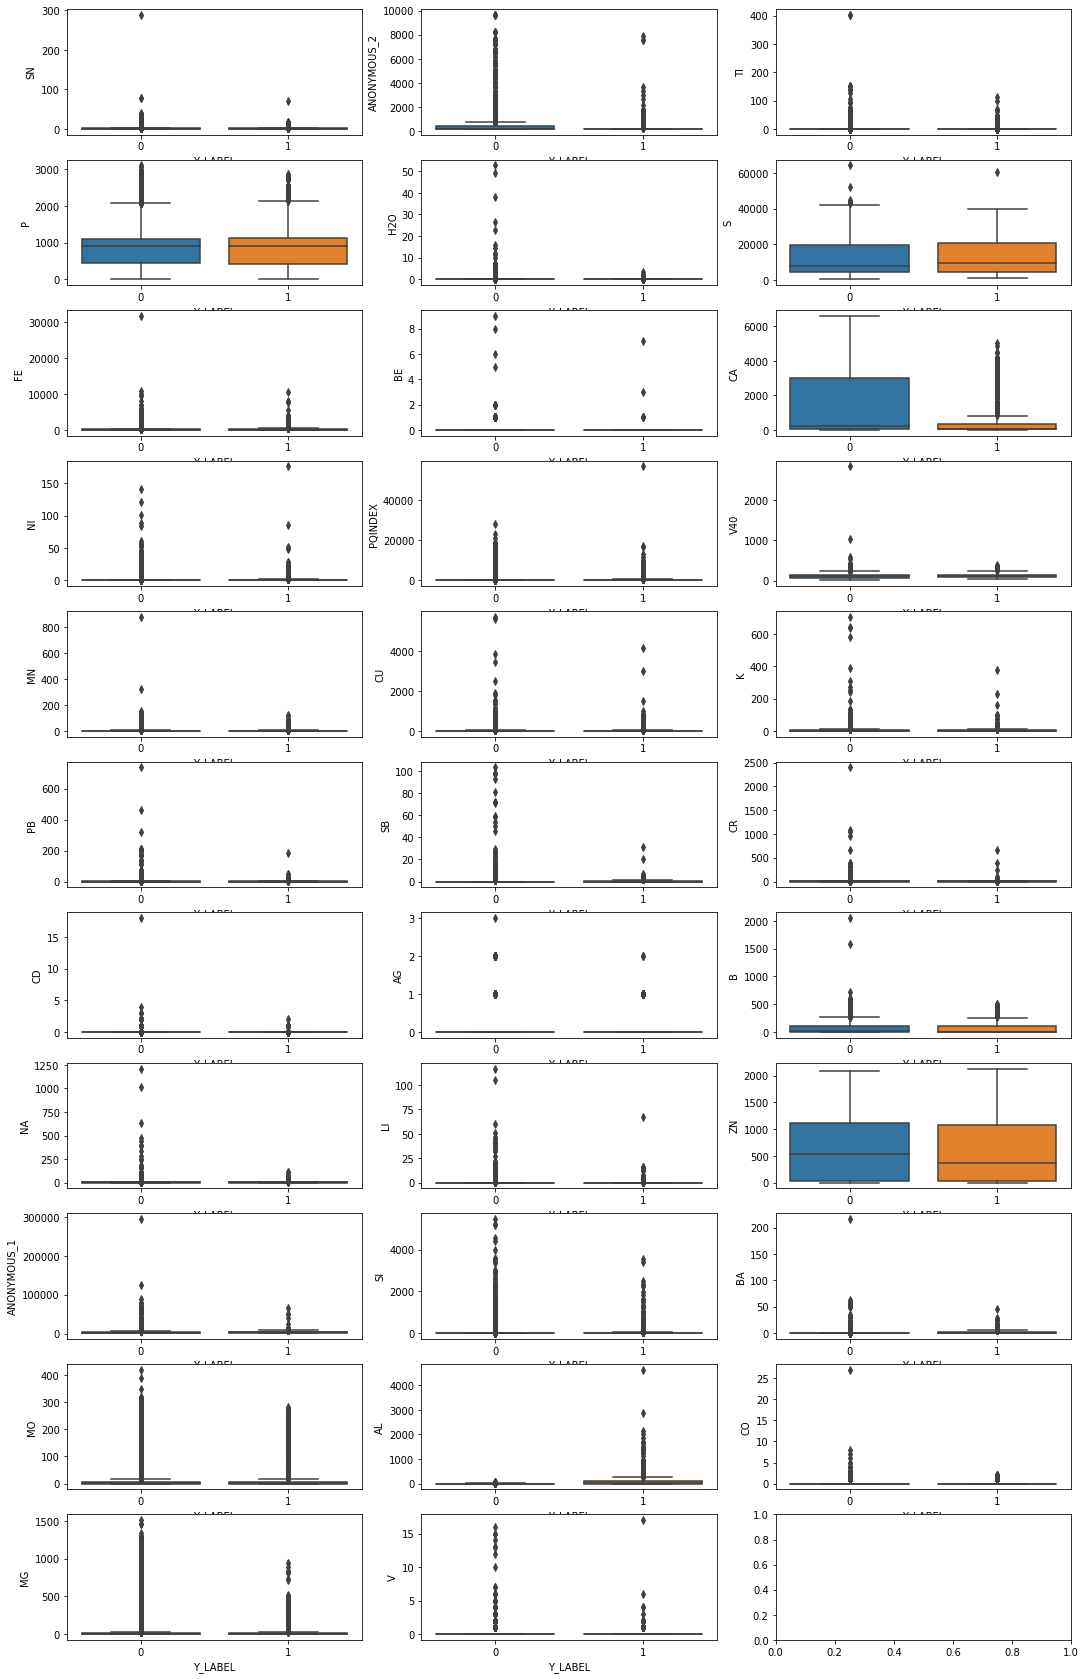

In [3300]:
box_plot(train)

In [3301]:
def skew_chart(df):
    세로열 = 3
    가로열 = int(len(df.columns)/세로열+1)

    fig, axes = plt.subplots(가로열, 3, figsize=(20, 30))
    a = 0
    for i, col in enumerate(skew_feats):
        b=i%3
        sns.distplot(df[col], bins=100, ax=axes[a, b])
        plt.gca().set_title(col)
        plt.subplots_adjust(hspace = 0.8)
        if b == 2:
            a += 1

In [3302]:
# skew_chart(train)

In [3303]:
skewness = train[numerical_cols].apply(lambda x: x.skew()).sort_values(ascending=False)
skewness

CD             55.839831
CR             54.368366
CO             49.810892
H2O            48.656666
NA             43.060333
BE             40.923712
SN             39.878475
PB             39.602904
MN             38.915313
BA             34.836012
TI             34.500761
K              31.113260
ANONYMOUS_1    30.451948
LI             28.675390
SB             25.174375
AL             22.037843
V              20.985827
CU             20.741422
NI             20.387033
FE             20.119119
SI             13.847020
V40            12.987017
PQINDEX         9.829113
ANONYMOUS_2     8.529989
AG              7.309733
MG              6.095664
MO              2.904525
B               2.847296
P               1.149380
S               0.806596
CA              0.390928
ZN              0.227683
dtype: float64

In [3304]:
for i in tqdm(range(CFG["log_transform_turn"])):
    skewness = train[numerical_cols].apply(lambda x: x.skew()).sort_values(ascending=False)
    skew_feats = skewness[skewness > CFG["skew_cut"]].index
    
    log_train = train[skew_feats].copy()
    log_train[skew_feats] = np.log1p(log_train[skew_feats])
        
    for col in skew_feats:
        train[col] = log_train[col]
    
    skewness = train[numerical_cols].apply(lambda x: x.skew()).sort_values(ascending=False)
#     print("-"*40)
#     print(skew_feats)
    print(skewness)
    
    for col in skew_feats:
        if col in test.columns:
            test[col] = np.log1p(test[col])
        else:
            pass

  0%|          | 0/1 [00:00<?, ?it/s]

BE             23.412466
H2O            18.578013
CD             11.733953
CO              9.008246
V               8.296009
AG              6.600190
LI              5.496954
TI              4.836962
NI              2.881386
SB              2.767385
BA              2.176642
SN              2.044310
AL              1.782754
ANONYMOUS_2     1.779987
PB              1.681511
MN              1.387217
CR              1.309447
SI              1.239047
MO              1.197475
MG              0.960658
ANONYMOUS_1     0.930168
PQINDEX         0.786814
CU              0.763561
K               0.608012
NA              0.605474
FE              0.273557
B               0.168986
CA             -0.201518
S              -0.324163
V40            -0.496896
ZN             -0.501953
P              -0.622552
dtype: float64


In [3305]:
# skew_chart(train)

## (3) Scaling

In [3306]:
categorical_features = ['ID','COMPONENT_ARBITRARY','SAMPLE_TRANSFER_DAY', 'YEAR', "Y_LABEL"]

In [3307]:
train.head(2)

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,...,PQINDEX,S,SB,SI,SN,TI,V,V40,ZN,Y_LABEL
0,TRAIN_00000,COMPONENT3,7.304516,y4,s2,5.303305,0.0,1.386294,4.543295,0.0,...,9.048410,9.969790,0.0,6.059123,1.098612,1.791759,0.0,5.043425,4.330733,0
1,TRAIN_00001,COMPONENT2,7.208600,y1,s3,5.929589,0.0,1.098612,2.995732,0.0,...,2.995732,7.019297,0.0,0.000000,0.000000,0.000000,0.0,3.806662,6.481577,0


In [3308]:
def get_values(value):
    return value.values.reshape(-1, 1)

for col in train.columns:
    if col not in categorical_features:   # 범주형 칼럼이 아니라면 표준화
        scaler = StandardScaler()
        train[col] = scaler.fit_transform(get_values(train[col]))
        if col in test.columns:
            test[col] = scaler.transform(get_values(test[col]))
            
train.head(2)

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,...,PQINDEX,S,SB,SI,SN,TI,V,V40,ZN,Y_LABEL
0,TRAIN_00000,COMPONENT3,-0.912752,y4,s2,-0.623928,-0.153746,0.144147,0.961928,-0.49312,...,2.758639,1.029866,-0.457769,3.161120,1.224939,3.210181,-0.154507,1.007861,-0.614230,0
1,TRAIN_00001,COMPONENT2,-1.076829,y1,s3,0.405018,-0.153746,-0.117480,0.116099,-0.49312,...,-0.524164,-2.246986,-0.457769,-1.685121,-0.549480,-0.264003,-0.154507,-1.939387,0.606862,0


## (4) 다중공선성 검토

In [3309]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3310]:
train1 = train.copy()

In [3311]:
train1 = train1[numerical_cols].astype(float)
train1.shape

(14095, 32)

In [3312]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(train1.values, i) for i in range(train1.shape[1])]
vif["features"] = train1.columns 
vif

,VIF Factor,features
0,1.618160,SN
1,1.067950,ANONYMOUS_2
2,2.766101,TI
3,1.787096,P
4,1.095033,H2O
5,4.755654,S
6,6.631926,FE
7,1.010727,BE
8,1.170182,CA
9,2.563408,NI


In [3313]:
vif_10이상 = vif[vif["VIF Factor"]> CFG["vif_cut"]]
vif_drop = vif_10이상["features"].tolist()
vif_drop

[]

In [3314]:
train1 = train1.drop(vif_drop,axis=1)

In [3315]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(train1.values, i) for i in range(train1.shape[1])]
vif["features"] = train1.columns 
vif.T

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
VIF Factor,1.61816,1.06795,2.766101,1.787096,1.095033,4.755654,6.631926,1.010727,1.170182,2.563408,...,1.085015,5.04447,1.136706,3.081186,1.278615,1.697127,1.214039,1.179731,2.088906,1.519409
features,SN,ANONYMOUS_2,TI,P,H2O,S,FE,BE,CA,NI,...,LI,ZN,ANONYMOUS_1,SI,BA,MO,AL,CO,MG,V


In [3316]:
# VIF 높은 칼럼 드랍
train.drop(vif_drop ,axis=1, inplace=True)

In [3317]:
print(f"드랍하기 전 칼럼 갯수 : {len(test.columns)}")
for col in vif_drop:
    if col in test.columns:
        test.drop(columns = col, axis = 1, inplace = True)
    else:
        pass
print(f"드랍후 칼럼 갯수 : {len(test.columns)}")

드랍하기 전 칼럼 갯수 : 19
드랍후 칼럼 갯수 : 19


## (5) 상관관계 검토

In [3318]:
train.columns

Index(['ID', 'COMPONENT_ARBITRARY', 'ANONYMOUS_1', 'YEAR',
       'SAMPLE_TRANSFER_DAY', 'ANONYMOUS_2', 'AG', 'AL', 'B', 'BA', 'BE', 'CA',
       'CD', 'CO', 'CR', 'CU', 'FE', 'H2O', 'K', 'LI', 'MG', 'MN', 'MO', 'NA',
       'NI', 'P', 'PB', 'PQINDEX', 'S', 'SB', 'SI', 'SN', 'TI', 'V', 'V40',
       'ZN', 'Y_LABEL'],
      dtype='object')

<AxesSubplot:>

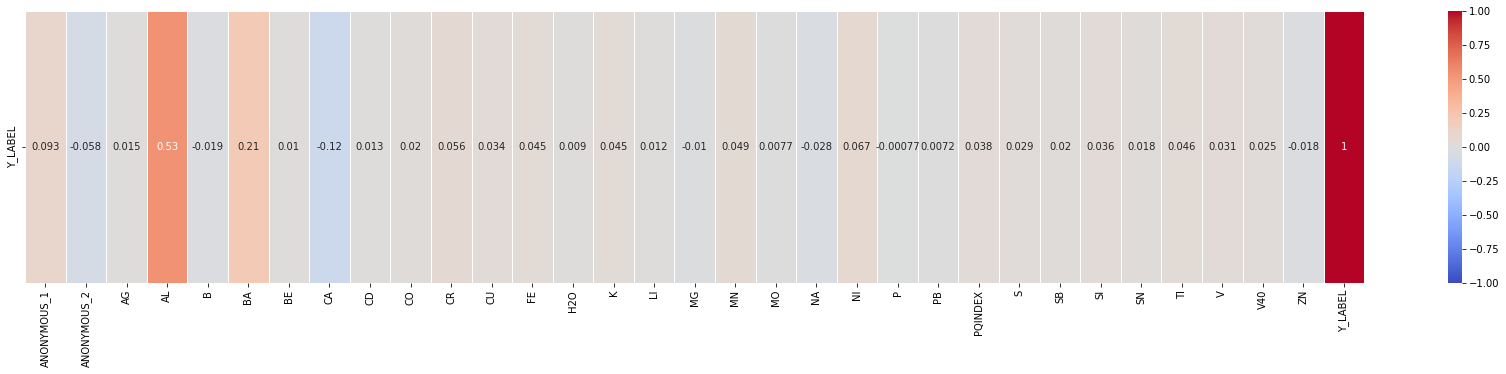

In [3319]:
fig = plt.figure(figsize=(30, 5))
sns.heatmap(train.loc[:,:].corr()[["Y_LABEL"]].T, annot=True, linewidth=1, cmap="coolwarm", vmin=-1, vmax=1)

In [3320]:
df_corr = pd.DataFrame(train.corr()["Y_LABEL"].sort_values(ascending=False))
df_corr

,Y_LABEL
Y_LABEL,1.000000
AL,0.531680
BA,0.205176
ANONYMOUS_1,0.092820
NI,0.067153
CR,0.056019
MN,0.048509
TI,0.046066
FE,0.045108
K,0.044821


In [3321]:
# 상관관계가 낮아서 제낄 칼럼 확인
cutline = CFG["corr_cut"]
df_corr1 = df_corr[(df_corr["Y_LABEL"] < cutline) & (df_corr["Y_LABEL"] > (cutline*-1))]
print(f"상관계수 커트라인 : {cutline}, 드랍 칼럼 개수 : {len(df_corr1.index)}")
df_corr1.sort_values

상관계수 커트라인 : 0.0075, 드랍 칼럼 개수 : 2


<bound method DataFrame.sort_values of      Y_LABEL
PB  0.007244
P  -0.000769>

In [3322]:
drop_columns = df_corr1.index.tolist()
drop_columns

['PB', 'P']

In [3323]:
print(f"드랍하기 전 칼럼 갯수 : {len(train.columns)}")
for col in drop_columns:
    if col in train.columns:
        train.drop(columns = col, axis = 1, inplace = True)
    else:
        pass
print(f"드랍후 칼럼 갯수 : {len(train.columns)}")

드랍하기 전 칼럼 갯수 : 37
드랍후 칼럼 갯수 : 35


In [3324]:
print(f"드랍하기 전 칼럼 갯수 : {len(test.columns)}")
for col in drop_columns:
    if col in test.columns:
        test.drop(columns = col, axis = 1, inplace = True)
    else:
        pass
print(f"드랍후 칼럼 갯수 : {len(test.columns)}")

드랍하기 전 칼럼 갯수 : 19
드랍후 칼럼 갯수 : 19


In [3325]:
# 상관관계 낮은 칼럼 드랍
# train.drop(df_corr1.index.tolist(), axis = 1, inplace=True)
# train.columns

## (6) 수치형 데이터 이상치 처리

In [3326]:
not_number_features = ['ID','COMPONENT_ARBITRARY', 'SAMPLE_TRANSFER_DAY','YEAR', "Y_LABEL"]
train.drop(columns = "ID", axis = 1, inplace = True)
test.drop(columns = "ID", axis = 1, inplace = True)

In [3327]:
#이상치 인덱스 확인 함수
def get_outlier(df=None, col=None, weight=1.5):
    target = df[col]
    quantile_25 = np.quantile(target, 0.25)
    quantile_75 = np.quantile(target, 0.75)
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    outlier_index = target[(target < lowest_val) | (target > highest_val)].index
    return outlier_index

In [3328]:
get_outlier(train, "CO")

Int64Index([   23,    35,    95,   106,   205,   224,   225,   250,   265,
              343,
            ...
            13739, 13756, 13794, 13798, 13812, 13999, 14021, 14049, 14059,
            14086],
           dtype='int64', length=297)

In [3329]:
이상치칼럼 = []
huddle = CFG["outlier_corr_cut"]  # 허들이상의 상관관계를 가진 칼럼에 대해서만 이상치 드랍
print(huddle)

for target1 in train.columns:
    if target1 not in not_number_features and ((df_corr.loc[[target1]].values[0][0] >= huddle) or (df_corr.loc[[target1]].values[0][0] <= (huddle*-1))):
        이상치칼럼.append(target1)
        
        outlier_index = get_outlier(train, target1)
        print(f"검토대상: {target1}, 상관관계: {df_corr.loc[[target1]].values[0][0]:.2f}, 드랍갯수: {len(outlier_index)}")
        
        train.drop(index=outlier_index, inplace=True)

    else:
        pass
    
# print(f"이상치칼럼: {target1}, "드랍갯수": {len(outlier_index)})

100


In [3330]:
if target1 in 이상치칼럼 :
    print(target1)
    outlier_index2 = get_outlier(test, target1)
    print(f"드랍대상 아웃라이어 인덱스 갯수 : {len(outlier_index2)}")

    test.drop(index=outlier_index, inplace=True)
else:
    pass

In [3331]:
train.head(2)

,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,BE,...,PQINDEX,S,SB,SI,SN,TI,V,V40,ZN,Y_LABEL
0,COMPONENT3,-0.912752,y4,s2,-0.623928,-0.153746,0.144147,0.961928,-0.49312,-0.054428,...,2.758639,1.029866,-0.457769,3.161120,1.224939,3.210181,-0.154507,1.007861,-0.614230,0
1,COMPONENT2,-1.076829,y1,s3,0.405018,-0.153746,-0.117480,0.116099,-0.49312,-0.054428,...,-0.524164,-2.246986,-0.457769,-1.685121,-0.549480,-0.264003,-0.154507,-1.939387,0.606862,0


#### 연도 칼럼을 원핫으로 유지할 필요가 있을까?

In [3332]:
# target = "YEAR"
# 정상 = train[train["Y_LABEL"] == 0][target]
# 이상= train[train["Y_LABEL"] == 1][target]
# plt.figure(figsize = (12,6))
# sns.distplot(정상,bins = 15, color="red")
# sns.distplot(이상,bins = 15, color="green")

In [3333]:
print(train[train["Y_LABEL"]==0]["COMPONENT_ARBITRARY"].value_counts())
print(train[train["Y_LABEL"]==1]["COMPONENT_ARBITRARY"].value_counts())

COMPONENT3    6415
COMPONENT1    3578
COMPONENT2    2110
COMPONENT4     789
Name: COMPONENT_ARBITRARY, dtype: int64
COMPONENT3    635
COMPONENT1    312
COMPONENT2    206
COMPONENT4     50
Name: COMPONENT_ARBITRARY, dtype: int64


In [3334]:
# additonal_drop_cols = ["YEAR"]
# train = train.drop(additonal_drop_cols, axis=1)
# test = test.drop(additonal_drop_cols, axis=1)
# print(train.columns)
# print(test.columns)

## (7) 인코딩

In [3335]:
def onehot_encode(df, target_list):
    ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(drop='first', sparse=False), [0,2,3])], remainder='passthrough')
    df = ct.fit_transform(df)
    df = pd.DataFrame(df)
    new_name = ct.get_feature_names()
    df.columns = new_name
    return df

In [3336]:
train = onehot_encode(train, [0,2,3])
train.columns

Index(['encoder__x0_COMPONENT2', 'encoder__x0_COMPONENT3',
       'encoder__x0_COMPONENT4', 'encoder__x1_y2', 'encoder__x1_y3',
       'encoder__x1_y4', 'encoder__x1_y5', 'encoder__x2_s2', 'encoder__x2_s3',
       'ANONYMOUS_1', 'ANONYMOUS_2', 'AG', 'AL', 'B', 'BA', 'BE', 'CA', 'CD',
       'CO', 'CR', 'CU', 'FE', 'H2O', 'K', 'LI', 'MG', 'MN', 'MO', 'NA', 'NI',
       'PQINDEX', 'S', 'SB', 'SI', 'SN', 'TI', 'V', 'V40', 'ZN', 'Y_LABEL'],
      dtype='object')

In [3337]:
test.columns

Index(['COMPONENT_ARBITRARY', 'ANONYMOUS_1', 'YEAR', 'ANONYMOUS_2', 'AG', 'CO',
       'CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V', 'V40',
       'ZN'],
      dtype='object')

In [3338]:
def onehot_encode1(df, target_list):
    ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(drop='first', sparse=False), [0,2])], remainder='passthrough')
    df = ct.fit_transform(df)
    df = pd.DataFrame(df)
    new_name = ct.get_feature_names()
    df.columns = new_name
    return df

In [3339]:
test = onehot_encode1(test, [0,2])
test.columns

Index(['encoder__x0_COMPONENT2', 'encoder__x0_COMPONENT3',
       'encoder__x0_COMPONENT4', 'encoder__x1_y2', 'encoder__x1_y3',
       'encoder__x1_y4', 'encoder__x1_y5', 'ANONYMOUS_1', 'ANONYMOUS_2', 'AG',
       'CO', 'CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V',
       'V40', 'ZN'],
      dtype='object')

## (8) train, test split

In [3340]:
all_X = train.drop(['Y_LABEL'], axis = 1)
all_y = train['Y_LABEL']
train_X, val_X, train_y, val_y = train_test_split(all_X, all_y, test_size=0.2, random_state=CFG['SEED'], stratify=all_y)

In [3341]:
# num_cols = train.columns
train_X.head(2)

,encoder__x0_COMPONENT2,encoder__x0_COMPONENT3,encoder__x0_COMPONENT4,encoder__x1_y2,encoder__x1_y3,encoder__x1_y4,encoder__x1_y5,encoder__x2_s2,encoder__x2_s3,ANONYMOUS_1,...,NI,PQINDEX,S,SB,SI,SN,TI,V,V40,ZN
3283,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-1.042979,...,0.803664,-0.645190,-2.052473,-0.457769,-0.806423,1.224939,-0.264003,-0.154507,-1.976748,0.550225
9759,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.396358,...,0.803664,0.561383,0.832469,-0.457769,-0.576328,-0.549480,-0.264003,-0.154507,0.873459,-1.344447


In [3342]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pc = pca.fit_transform(train_X)
pc_y = np.c_[pc,train_y]
df = pd.DataFrame(pc_y,columns=['PC1','PC2','Y_LABEL'])
df.head(2)

,PC1,PC2,Y_LABEL
0,-0.621483,2.280919,0.0
1,0.982596,-2.257360,0.0


In [3343]:
print(f"total explained variance : {pca.explained_variance_ratio_.sum()*100:.3f}")

total explained variance : 29.690


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

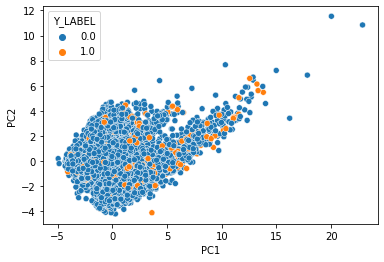

In [3344]:
sns.scatterplot(data=df,x='PC1',y='PC2',hue='Y_LABEL')

In [3345]:
import plotly.express as px
from sklearn.decomposition import PCA

# df = px.data.iris()
# X = df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]

pca = PCA(n_components=3)
components = pca.fit_transform(train_X)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=train_y,
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

In [3346]:
import pickle

#저장하기
with open(f"./data/{file_version}_refined_train_X", 'wb') as pickle_filename:
	pickle.dump(train_X, pickle_filename)

with open(f"./data/{file_version}_refined_train_y", 'wb') as pickle_filename:
	pickle.dump(train_y, pickle_filename)
    
with open(f"./data/{file_version}_refined_val_X", 'wb') as pickle_filename:
	pickle.dump(val_X, pickle_filename)

with open(f"./data/{file_version}_refined_val_y", 'wb') as pickle_filename:
	pickle.dump(val_y, pickle_filename)
    
with open(f"./data/{file_version}_refined_test", 'wb') as pickle_filename:
	pickle.dump(test, pickle_filename)